# Dictionary Methods 

This code will apply the dictionary method from Yul et. al to each post and evaluate the performance afterwards. 

## 0. Preparation

### 0.1 Load libraries

In [32]:
import pandas as pd
from datasets import load_dataset
import json
from pattern.en import pluralize, singularize
import spacy
from spacy.lang.en import English
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk import ngrams
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col
import numpy as np
import simpledorff

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\anasa\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\anasa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 0.2 Setting for plots

In [33]:
title_font={'fontsize': 14,
 'fontweight' : 'bold',
 'verticalalignment': 'baseline'}
palette='viridis'
my_cmap = plt.get_cmap("viridis")

### 0.3 Define functions

#### 0.3.1 Text preprocessing
* For the pre-processing of the posts we used code from class

In [34]:
# Define the parser 
parser = English()
def tokenize(text):
    """
    This fuction (from the lecture), replaces usernames and URLs, 
    turn the text to lowercase and returns the tokenized text.

    Parameters
    ----------
    text : str
        Text to be tokenized.

    Returns
    -------
    lda_tokens : list
        List of preprocessed tokens.

    """
    lda_tokens = []
    tokens = parser(text)
    for token in tokens:
        if token.orth_.isspace():
            continue
        elif token.like_url:
            lda_tokens.append('URL')
        elif token.orth_.startswith('@'):
            lda_tokens.append('SCREEN_NAME')
        else:
            lda_tokens.append(token.lower_)
    return lda_tokens

In [35]:
#define list of stopwords in english
en_stop = set(nltk.corpus.stopwords.words('english'))
def get_tokens(text):
    """
    This function tokensizes the text. 
    Afterwards it removes punctuation and stopwords, and singularises the words.

    Parameters
    ----------
    text : str
        Text to be tokenized..

    Returns
    -------
    tokens : list
        List of preprocessed tokens.

    """
    tokens = tokenize(text)
    # remove token with lenght of 2 or less (punctuation etc.)
    tokens = [token for token in tokens if len(token) > 2]

    # remove stopwords
    tokens = [token for token in tokens if token not in en_stop]

    # sigularize words to facilitate match with dictionary 
    tokens= [singularize(token) for token in tokens]

    return tokens

In [36]:
def extract_ngrams_tokens(tokens, num):
    """
    This function extracts the specified n-grams from a list of tokens.

    Parameters
    ----------
    tokens : list
        List of preprocessed tokens.
    num : int
        n for the n-grams.
        n=1 -> unigrams
        n=2 -> bigrams

    Returns
    -------
    list
        List of specified n-grams.

    """
    n_grams = ngrams(tokens, num)
    return [ ' '.join(grams) for grams in n_grams]

#### 0.3.2 Assign Target categories

In [37]:
#build function for categories 
def get_categories(unigram,bigram,id,store_dict):
    """
    This function matches unigrams and bigrams with a target category from the target dictionary.
    It stores the ids of the instances in a new dictionary and returns the categories.

    Parameters
    ----------
    unigram : list
        List of unigrams
    bigram : list
        List of bigrams
    id : str or float
        id of the post that is stored in the new dictionary.
    store_dict : dict
        Dictionary with categories, where the ids should be stored.

    Returns
    -------
    categories : list
        List of categories assigned to the text.

    """
    categories=[]
    for token in unigram: 
        for cat in target_dict:
            if token in target_dict[f'{cat}'] and cat not in categories: 
                categories.append(str(cat))
                store_dict[f'{cat}'].append(id)
    for token in bigram: 
        for cat in target_dict:
            if token in target_dict[f'{cat}'] and cat not in categories: 
                categories.append(str(cat))
                store_dict[f'{cat}'].append(id)
    return categories

In [38]:
def get_target_categories(text,id,store_dict): 
    """
    This fuction takes an instance, preprocess it and assigns it to its target categories.

    Parameters
    ----------
    text : str
        Text of the instance.
    id : str or float
        id of the instance.
    store_dict : dict
        Dictionary with categories, where the ids should be stored.

    Returns
    -------
    categories : list
        List of categories assigned to the text.

    """ 
    # tokenize text
    tokens=get_tokens(text)

    # extract unigrams and bigrams
    bigrams=extract_ngrams_tokens(tokens, 2)
    unigram=extract_ngrams_tokens(tokens, 1)

    # classify categories
    categories=get_categories(unigram,bigrams,id,store_dict)

    # appned id to no target
    if categories==[]: 
        store_dict['no target'].append(id)

    return categories 

In [39]:
def init_store_dict():
    """
    This fuction creates an empty dictionary with the categories from the target dictionary. 

    Returns
    -------
    store_dict : dict
        Empty dictionary with the categories from the target dictionary

    """
    store_dict={key:[] for key in target_dict.keys()}
    store_dict['no target']=[]

    return store_dict

In [40]:
def assign_targets(df, txt_col='text', post_id='instance_id'):
    """
    This function takes a dataframe with instances, assigns them to target categories, 
    which are tored in a new column and in dictionary which is returned. 

    Parameters
    ----------
    df : pandas dataframe
        Dataframe in question.
    txt_col : str, optional
        Name of the column where the instances are stored. The default is 'text'.
    post_id : str, optional
        Name of the column where the instance ids are stored. The default is 'instance_id'.

    Returns
    -------
    dict_store : dict
        Dictionary which stores the instance ids in each category. 

    """
    dict_store= init_store_dict()
    df['detected_target']=[get_target_categories(text,ids,dict_store) for text,ids in zip(df[txt_col],df[post_id])]
    return dict_store

#### 0.3.3 Plots

In [41]:
def plot_target_ditribution(target_dict,dataset_name,div_colors):
    """
    This function plots the distribution between targeted and untargeted posts,
    and the distribution across targets, using a given target dictionary. 

    Parameters
    ----------
    target_dict : dict
        Dictionary that stores the instance ids for each target.
    dataset_name : str
        The name of the dataset, which should be displayed on the plot.
    div_colors : int
        Parameter to regulate the color scale.

    Returns
    -------
    None. Shows the plot. 

    """
    #create a dictionary with the number of instance for each category 
    len_dict={key:len(target_dict[f'{key}']) for key in target_dict.keys()}

    #plot targeted vs. untargeted
    #define values 
    untargeted=len_dict['no target']
    #remove non-target 
    len_dict.pop('no target')
    targeted=sum(len_dict.values())

    names= ['targeted','untargeted']
    values= [targeted,untargeted]

    fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16, 6),width_ratios=[1,2])
    ax[0].bar(range(2), values, tick_label=names, color=my_cmap(0.15),alpha=0.9)
    ax[0].set_title('Targeted vs Untargeted',fontdict=title_font)
    ax[0].set_ylabel('Number of instances')


    #plot within values
    #define values 

    names= list(len_dict.keys())
    values= list(len_dict.values())
    colors=[my_cmap(val/div_colors) for val in values]
    #fig, ax = plt.subplots(figsize=(10, 6))
    ax[1].bar(range(len(len_dict)), values, tick_label=names, color=colors,alpha=0.9)
    ax[1].set_xticks(range(len(len_dict)),labels=names,rotation=90)
    ax[1].set_title('Distribution of target categories ',fontdict=title_font)
    #ax[1].set_ylabel('Number of instances')
    ax[1].set_xlabel('Target Gruop')
    ax[1].set_ylabel('Number of instances')
    fig.suptitle(f'{dataset_name}\n', size=16, fontweight='bold')
    plt.show()

#### 0.3.4 Validation

In [42]:
def create_truecat_series(category,df,true_col, experiment_col='HITId',annotator_col='WorkerId'):
    """
    This fuction processes a dataframe and determines for each post,
    if it belongs to a given target category based on annotations.

    Parameters
    ----------
    category : str
        Name of the category for which the mapping shoud be done.
    df : pandas dataframe
        Daframe with the annotations
    true_col : str
        Name of the column in which the annotations for targets category are stored.
    experiment_col : str, optional
        Name of the column in which the instance_ids are stored. The default is 'HITId'.
    annotator_col : str, optional
        Name of the column in which the annotator_ids are stored. The default is 'WorkerId'.

    Returns
    -------
    classification : pandas dataframe
        Dataframe of posts with true labels.
    agreement : float
        Annotator agremment measured using Krippendorff's alpha.

    """
    #create column that maps if the targetcategory is found
    df[f'{category}']=[f'{category}' if cat==f'{category}' else f'not {category}' for cat in df[f'{true_col}']]

    #calculate annotator agreement 
    agreement=simpledorff.calculate_krippendorffs_alpha_for_df(df, experiment_col=experiment_col,annotator_col=annotator_col,class_col=f'{category}')
    
    #drop the target category
    df=df[[f'{experiment_col}',f'{annotator_col}',f'{category}']]
    #sort by both ids on the first level and category on the sencond --> by droping duplicates the first observation is kept in this case the one with category if there is any 
    df_sorted=df.sort_values(by=[f'{experiment_col}',f'{annotator_col}',f'{category}'])
    df_sorted=df_sorted.drop_duplicates(subset=[f'{experiment_col}',f'{annotator_col}'],keep='first')

    #turn category classification into a binary variable
    df_sorted[f'd_{category}']=df_sorted[f'{category}']==f'{category}'

    #group by each instance an get the proportion classified as a category
    classification=df_sorted.groupby(by=experiment_col).mean()   

    classification[f'true_{category}']=[f'{category}' if mean >= 0.5 else f'not {category}' for mean in classification[f'd_{category}']]

    #sort by experiment_col so the series has the same oreder 
    classification.sort_values(by=f'{experiment_col}',inplace=True)


    print(f'Annotator agreement (kippendorfalpha) of {category}: {round(agreement,4)}')

    return classification, agreement 

In [43]:
def evaluate(val_df,category): 
    """
    This fuction plots confusion matrices and prints performance measures 
    for a given category of a validation dataframe.

    Parameters
    ----------
    val_df : pandas dataframe
        Dataframe that contains true and predicted lables 
    category : str
        Name of the category in question.

    Returns
    -------
    None. Prints confusion matrices and performance measures. 

    """

    #define values
    true=val_df[f'true_{category}']
    pred=val_df[f'detected_{category}']

    #create confusion matrix
    conf_matrix=confusion_matrix(true, pred, labels=[f'{category}',f'not {category}'] )
    #plot
    disp=ConfusionMatrixDisplay(confusion_matrix=conf_matrix,
                              display_labels=[f'{category}',f'not {category}'])
    disp.plot()
    plt.title(f'Target category: {category}\n ', fontdict=title_font)
    plt.show()

    #print measures of performance
    print(f'Metrics for {category}\n')
    accuracy= accuracy_score(true,pred)
    print("Accuracy:", round(accuracy,3))

    precision = precision_score(true, pred, pos_label=f'{category}')
    print("Precision:", round(precision,3))

    recall = recall_score(true, pred, pos_label=f'{category}')
    print("Recall:", round(recall,3))

    f1 = f1_score(true, pred, pos_label=f'{category}')
    print("F1-Score:", round(f1,3))

## 1. Implementation dictionary methods

### 1.1 Load Data and dictionary 

In [44]:
# POPQUORN
pop_df = pd.read_csv("preprocessed data/popquorndata.csv")

# Social Bias Inference Corpus
sbf_df= pd.read_csv("preprocessed data/socialbiascorpus.csv")

# Merged Data 
all_df= pd.read_csv("preprocessed data/merged_dataset.csv")

In [45]:
# change the the type of worker id
sbf_df['WorkerId']=sbf_df['WorkerId'].astype(str)

In [46]:
with open('raw data/target_dictionary.json') as file:
    target_dict = json.load(file)

### 1.3 Implement method

* Extract post id and content of the post

In [47]:
# POPQUORN
pop_df_txt=pop_df[["instance_id","text"]]
pop_df_txt=pop_df_txt.drop_duplicates(ignore_index=True)

# SBIC
sbf_df_txt=sbf_df[['HITId','post']]
sbf_df_txt=sbf_df_txt.drop_duplicates(ignore_index=True)

# Merged Dataset
all_df_txt=all_df[['instance_id','text']]
all_df_txt=all_df_txt.drop_duplicates(ignore_index=True)

* rename columns of SBIC for easiar applicaton

In [48]:
rename_dict={'HITId':'instance_id','post':'text'}
sbf_df_txt.rename(columns=rename_dict,inplace=True)

Assign target categories 
* Initialize a dictionary to store the ids in the different categories 
* Create a column in each where the target categories are stored

In [49]:
# POPQUORN
pop_targets=assign_targets(pop_df_txt)

# SBIC
sbf_targets=assign_targets(sbf_df_txt)

# Merged Dataset
all_targets=assign_targets(all_df_txt)


In [50]:
#store the ids of the merged dataset
with open("preprocessed data/target_distribution.json", "w") as file: 
    json.dump(all_targets, file)

### 1.4 Example for the slides

In [51]:
text=sbf_df_txt['text'][1]
_id=sbf_df_txt['instance_id'][1]

# Show output after preprocessing
tokens=get_tokens(text)

# extract unigrams and bigrams
bigrams=extract_ngrams_tokens(tokens, 2)
unigram=extract_ngrams_tokens(tokens, 1)

# print text and text after preprocessing
print( text, '\n')
print( unigram, '\n')
print( bigrams, '\n')

RT @iBeZo: Stupid fucking nigger LeBron. You flopping stupid jungle bunny monkey faggot. 

['SCREEN_NAME', 'stupid', 'fucking', 'nigger', 'lebron', 'flopping', 'stupid', 'jungle', 'bunny', 'monkey', 'faggot'] 

['SCREEN_NAME stupid', 'stupid fucking', 'fucking nigger', 'nigger lebron', 'lebron flopping', 'flopping stupid', 'stupid jungle', 'jungle bunny', 'bunny monkey', 'monkey faggot'] 



### 1.5 Exploration target categories 

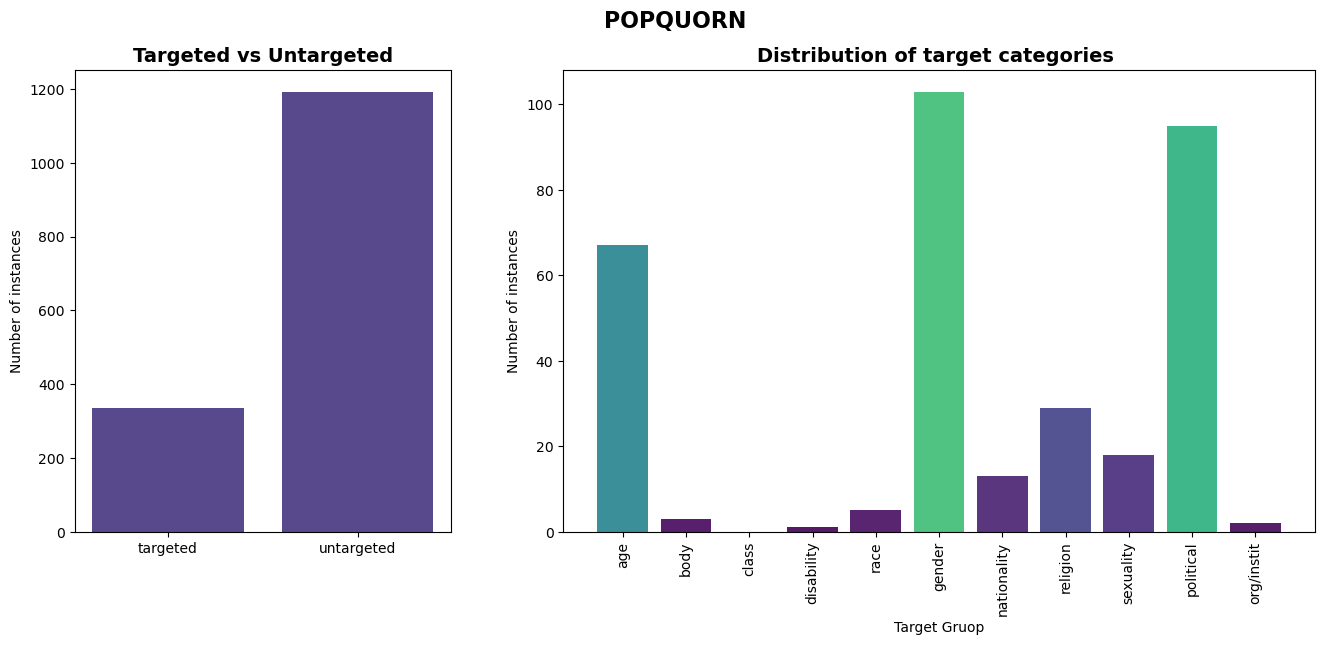

In [52]:
# POPQUORN
plot_target_ditribution(target_dict=pop_targets,dataset_name='POPQUORN',div_colors=150)

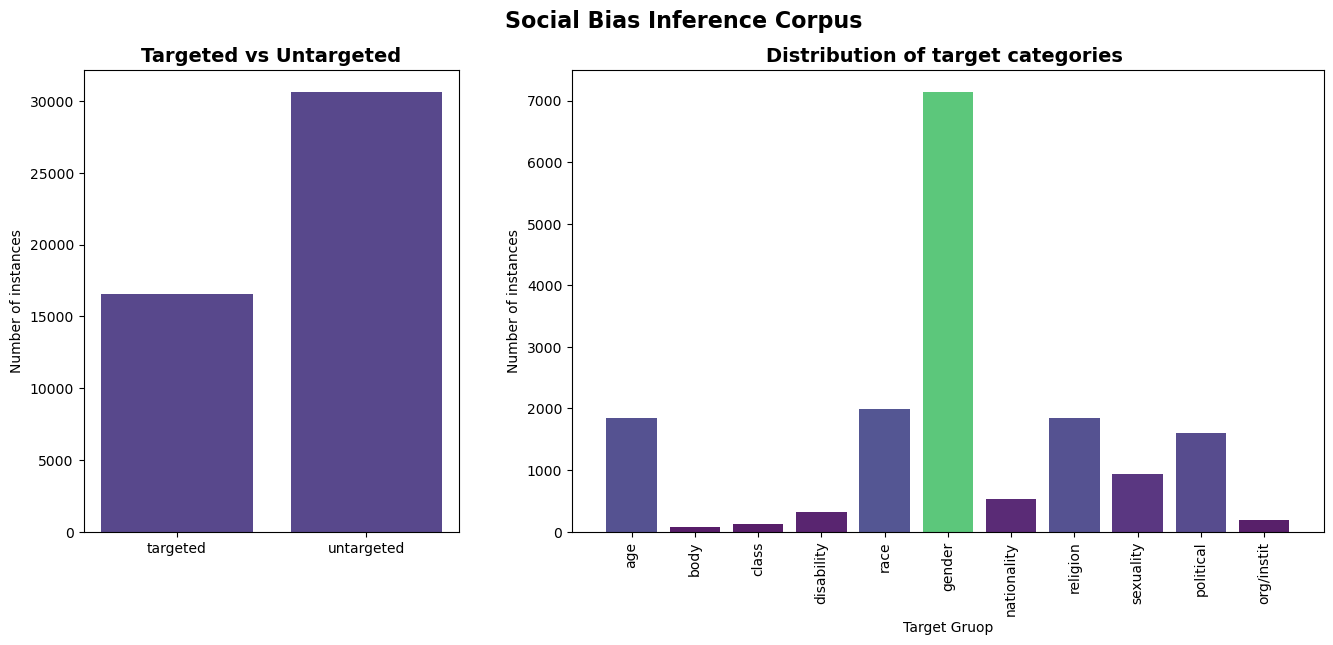

In [53]:
# SBIC
plot_target_ditribution(target_dict=sbf_targets,dataset_name='Social Bias Inference Corpus',div_colors=10000)

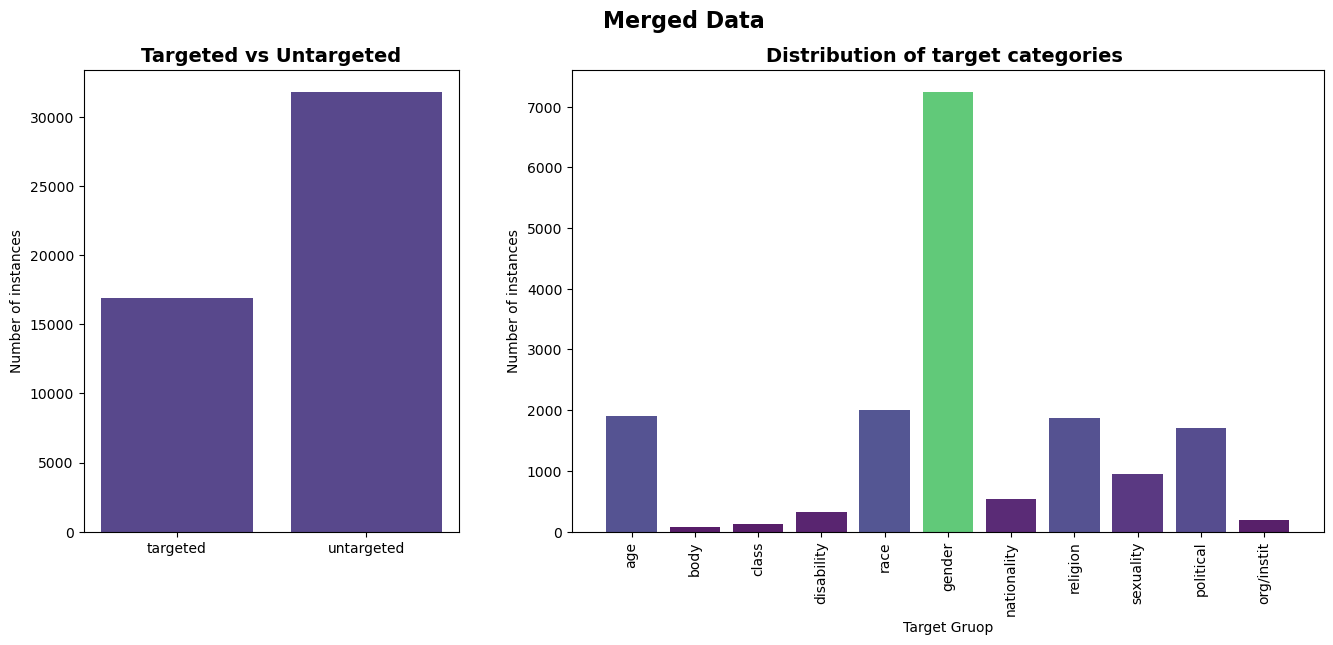

In [54]:
# Merged Data
plot_target_ditribution(target_dict=all_targets,dataset_name='Merged Data',div_colors=10000)

##  2. Validation

### 2.1 TargetCategory column

Plot distributions 

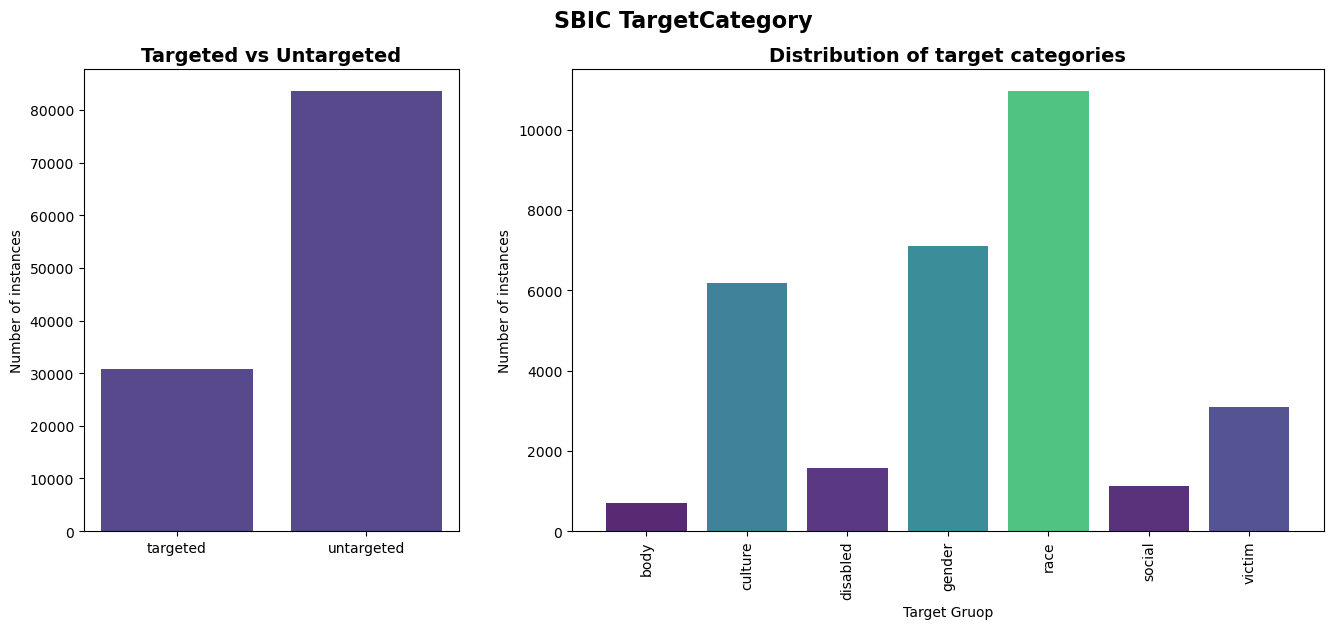

In [55]:
#define values
targets=sbf_df.groupby('targetCategory',dropna=False).size()

untargeted=targets[-1]
#remove non-target 
targeted=sum(targets[:-1])

#plot
names= ['targeted','untargeted']
values= [targeted,untargeted]

fig, ax = plt.subplots(nrows=1, ncols=2,figsize=(16, 6),width_ratios=[1,2])
ax[0].bar(range(2), values, tick_label=names, color=my_cmap(0.15),alpha=0.9)
ax[0].set_title('Targeted vs Untargeted',fontdict=title_font)
ax[0].set_ylabel('Number of instances')

# for distribution across targets
#define values 
names= list(targets[:-1].index)
values= list(targets[:-1])
colors=[my_cmap(val/16000) for val in values]

ax[1].bar(range(len(names)), values, tick_label=names, color=colors,alpha=0.9)
ax[1].set_xticks(range(len(names)),labels=names,rotation=90)
ax[1].set_ylabel('Number of instances')
ax[1].set_xlabel('Target Gruop')
ax[1].set_title('Distribution of target categories',fontdict=title_font)

fig.suptitle('SBIC TargetCategory\n', size=16, fontweight='bold')
plt.show()


### 2.2 Generate true label and performance measures

In [56]:
anotations_cat=sbf_df[['HITId','WorkerId','targetCategory']]

In [57]:
c_gender, agree_gender=create_truecat_series(category='gender',df=anotations_cat,true_col='targetCategory')
c_race, agree_race=create_truecat_series(category='race',df=anotations_cat,true_col='targetCategory')
c_disabled, agree_disabled=create_truecat_series(category='disabled',df=anotations_cat,true_col='targetCategory')

C:\Users\anasa\AppData\Local\Temp\ipykernel_14736\3871828554.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{category}']=[f'{category}' if cat==f'{category}' else f'not {category}' for cat in df[f'{true_col}']]
C:\Users\anasa\AppData\Local\Temp\ipykernel_14736\3871828554.py:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  classification=df_sorted.groupby(by=experiment_col).mean()
C:\Users\anasa\AppData\Local\Temp\ipykernel_14736\3871828554.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try usin

Annotator agreement (kippendorfalpha) of gender: 0.8917


C:\Users\anasa\AppData\Local\Temp\ipykernel_14736\3871828554.py:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  classification=df_sorted.groupby(by=experiment_col).mean()
C:\Users\anasa\AppData\Local\Temp\ipykernel_14736\3871828554.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{category}']=[f'{category}' if cat==f'{category}' else f'not {category}' for cat in df[f'{true_col}']]


Annotator agreement (kippendorfalpha) of race: 0.9066
Annotator agreement (kippendorfalpha) of disabled: 0.9108


C:\Users\anasa\AppData\Local\Temp\ipykernel_14736\3871828554.py:43: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  classification=df_sorted.groupby(by=experiment_col).mean()


In [58]:
c_gender

,d_gender,true_gender
HITId,,
301KG0KX9CF8K5JONRZNDVHCKE12H0,0.0,not gender
301KG0KX9CF8K5JONRZNDVHCKNPH2L,0.0,not gender
301KG0KX9CF8K5JONRZNDVHCKNQ2H7,0.0,not gender
301KG0KX9CF8K5JONRZNDVHCPOAH2D,0.0,not gender
301KG0KX9CF8K5JONRZNDVHCPOB2HZ,0.0,not gender
...,...,...
3ZZAYRN1I6LCWLZOAJE9YRN343ZTO2,0.0,not gender
3ZZAYRN1I6LCWLZOAJE9YRN3WDROT1,0.0,not gender
3ZZAYRN1I6LCWLZOAJE9YRN3WMFTOC,0.0,not gender


In [59]:
pd.DataFrame({'gender':agree_gender,'race':agree_race, 'disabled':agree_disabled}, index=['KDA'])

,gender,race,disabled
KDA,0.89174,0.906612,0.910816


Merge true labels with detected label

In [60]:
true_class=c_gender.merge(c_race,left_index=True,right_index=True).merge(c_disabled,left_index=True,right_index=True)
true_class.head(4)

,d_gender,true_gender,d_race,true_race,d_disabled,true_disabled
HITId,,,,,,
301KG0KX9CF8K5JONRZNDVHCKE12H0,0.0,not gender,0.5,race,0.5,disabled
301KG0KX9CF8K5JONRZNDVHCKNPH2L,0.0,not gender,1.0,race,0.0,not disabled
301KG0KX9CF8K5JONRZNDVHCKNQ2H7,0.0,not gender,0.0,not race,0.0,not disabled
301KG0KX9CF8K5JONRZNDVHCPOAH2D,0.0,not gender,0.0,not race,0.0,not disabled


In [61]:
# Map detected labels 

#sort
sbf_sorted=sbf_df_txt.sort_values(by='instance_id')
sbf_sorted.reset_index(inplace=True)

#map each category 
for cat in ['gender','race']:
    sbf_sorted[f'detected_{cat}']=[f'{cat}' if cat in targets else f'not {cat}' for targets in sbf_sorted['detected_target']]

#for disabled it differs a litle
sbf_sorted[f'detected_disabled']=['disabled' if 'disability' in targets else 'not disabled' for targets in sbf_sorted['detected_target']]

In [62]:
# Merge 
val_sbf=pd.merge(left=sbf_sorted, right=true_class, left_on='instance_id', right_index=True)
val_sbf=val_sbf.drop('index',axis=1)
val_sbf.head(4)

,instance_id,text,detected_target,detected_gender,detected_race,detected_disabled,d_gender,true_gender,d_race,true_race,d_disabled,true_disabled
0,301KG0KX9CF8K5JONRZNDVHCKE12H0,what do you call a high person with downs synd...,[],not gender,not race,not disabled,0.0,not gender,0.5,race,0.5,disabled
1,301KG0KX9CF8K5JONRZNDVHCKNPH2L,what do you call an albino black person ? an a...,"[class, race]",not gender,race,not disabled,0.0,not gender,1.0,race,0.0,not disabled


Evaluate each category

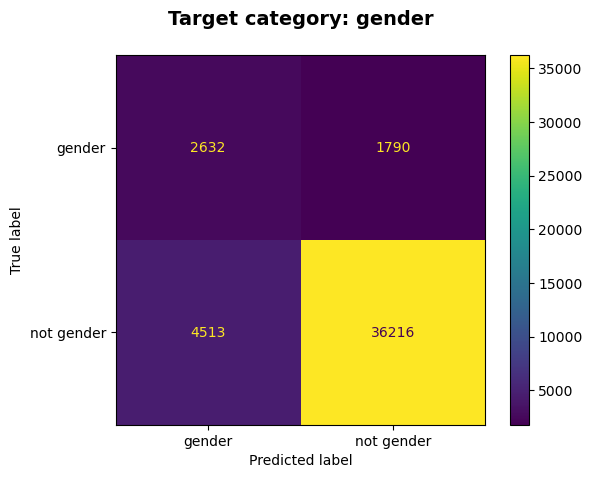

Metrics for gender

Accuracy: 0.86
Precision: 0.368
Recall: 0.595
F1-Score: 0.455


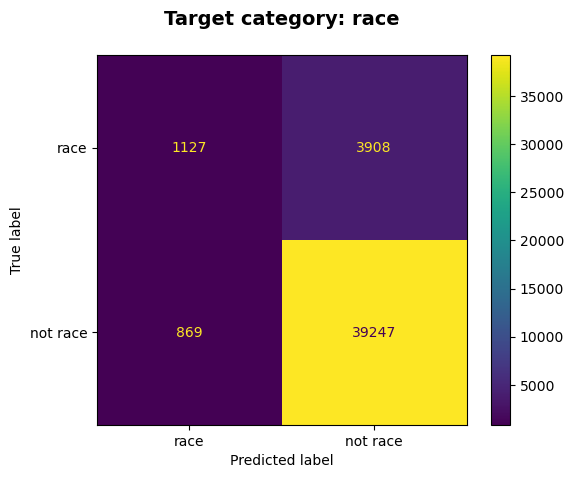

Metrics for race

Accuracy: 0.894
Precision: 0.565
Recall: 0.224
F1-Score: 0.321


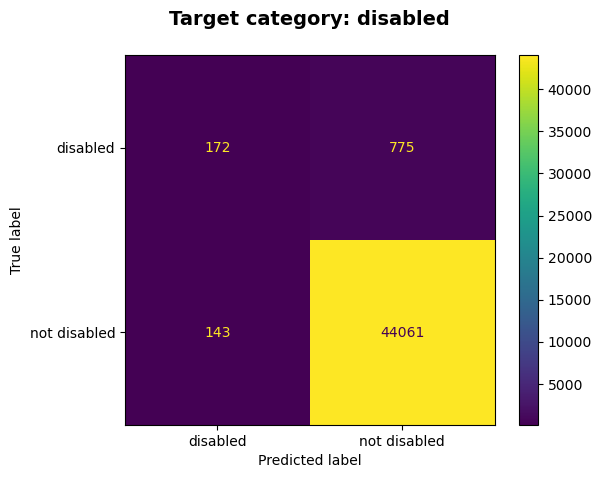

Metrics for disabled

Accuracy: 0.98
Precision: 0.546
Recall: 0.182
F1-Score: 0.273


In [63]:
for cat in ['gender','race','disabled']:
    evaluate(val_df=val_sbf,category=f'{cat}')

### 2.3 Run mixed effects to validate results

In [64]:
#divive if true gender 
sbf_gendertarget=val_sbf[val_sbf['true_gender']=='gender']
sbf_notgendertarget=val_sbf[val_sbf['true_gender']=='not gender']

#extract keys
ids_gender=sbf_gendertarget['instance_id']
ids_nogender=sbf_notgendertarget['instance_id']

In [65]:
true_gender=all_df.merge(ids_gender, left_on='instance_id',right_on='instance_id')
true_notgender=all_df.merge(ids_nogender, left_on='instance_id',right_on='instance_id')

In [66]:
# Check if merging worked properly
print(len(true_gender) + len(true_notgender),len(all_df[all_df['Dataset']=='SBIC']))

113373 113373


Run models

In [67]:
m_gen = smf.mixedlm("offensiveness_merge ~ gender+race+age", true_gender, groups=true_gender["instance_id"])
mf_gen = m_gen.fit()

m_nogen = smf.mixedlm("offensiveness_merge ~ gender+race+age", true_notgender, groups=true_notgender["instance_id"])
mf_nogen = m_nogen.fit()

c:\Users\anasa\anaconda3\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


Print results so that they can be exported to latex

In [68]:
var_order=['Intercept','gender[T.Woman]','gender[T.Non-binary]',
           'race[T.Black or African American]','race[T.Hispanic or Latino]','race[T.Native American]','race[T.White]','race[T.Other]', 
           'age[T.25-29]','age[T.30-34]','age[T.35-39]','age[T.40-44]','age[T.45-49]','age[T.50-54]','age[T.54-59]','age[T.60-64]','age[T.>65]',
           'Group Var']

In [69]:
print(summary_col([mf_gen, mf_nogen],
                  float_format='%.3f', 
                  model_names=['Gender','Not Gender'],
                  info_dict = {"N":lambda x:(x.nobs)},
                  stars=True, regressor_order=var_order).as_latex())

\begin{table}
\caption{}
\label{}
\begin{center}
\begin{tabular}{lll}
\hline
                                  & Gender    & Not Gender   \\
\hline
Intercept                         & 0.953***  & 0.382***     \\
                                  & (0.009)   & (0.004)      \\
gender[T.Woman]                   & 0.003     & -0.013***    \\
                                  & (0.004)   & (0.002)      \\
gender[T.Non-binary]              & 0.002     & 0.125        \\
                                  & (0.138)   & (0.197)      \\
race[T.Black or African American] & 0.010     & 0.060***     \\
                                  & (0.014)   & (0.007)      \\
race[T.Hispanic or Latino]        & -0.001    & 0.106***     \\
                                  & (0.011)   & (0.006)      \\
race[T.Native American]           & 0.067**   & 0.076***     \\
                                  & (0.027)   & (0.017)      \\
race[T.White]                     & -0.004    & 0.065***     \\
                    